In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import h5py as h5
from pathlib import Path
import tables
import sys
from importlib import reload

import psana as ps
sys.path.append('/cds/group/psdm/sw/tools/smalldata_tools/latest')
from smalldata_tools.DetObject import DetObject, DetObjectFunc
from smalldata_tools.ana_funcs.roi_rebin import ROIFunc, projectionFunc
from smalldata_tools.SmallDataUtils import setParameter, getUserData, getUserEnvData

In [2]:
pwd

'/cds/home/e/espov/dataAna'

In [12]:
""" Add your functions here. Reload allows you to take new
changes in without having to reset the kernel. """
# import your_ana_funcs as funcs
# relood(funcs)

' Add your functions here. Reload allows you to take new\nchanges in without having to reset the kernel. '

In [4]:
plt.style.use('dark_background')
#matplotlib.rcParams.keys()
plt.rcParams['figure.figsize'] = (10, 6)
plt.rc('font', size=12)
length = 8
width = 1.5
plt.rcParams['xtick.major.size'] = length 
plt.rcParams['ytick.major.size'] = length
plt.rcParams['xtick.major.width'] = width
plt.rcParams['ytick.major.width'] = width

# Exp and run, get datasource

In [5]:
run = 239
exp = 'mfxc00118'

# If on ffb:
# dsname = 'exp={}:run={}:dir=/cds/data/drpsrcf/{}/{}/xtc'.format(exp,run,exp[:3],exp)
# On psana:
dsname = 'exp={}:run={}'.format(exp,run,exp[:3],exp)

ds = ps.MPIDataSource(dsname)
dets = ds.detnames('epics')

ds.detnames()

[('NoDetector.0:Evr.0', 'evr0', ''),
 ('MfxEndstation.0:Rayonix.0', 'Rayonix', ''),
 ('EBeam', '', ''),
 ('PhaseCavity', '', ''),
 ('FEEGasDetEnergy', '', ''),
 ('FEE-SPEC0', '', ''),
 ('MFX-DG1-BMMON', '', ''),
 ('MFX-DG2-BMMON', '', ''),
 ('ControlData', '', '')]

# Set detObject and ana function

This is where the detector and the analysis function are defined. The example runs the ROI function on the Rayonix detector.

In [6]:
det = DetObject('Rayonix', ds.env(), int(run))

func_dict = {}
func_dict['ROI'] = [[10,100],[50,80]]
func_dict['axis'] = 0
func_dict['thresADU'] = None
func_dict['writeArea'] = True
func = ROIFunc(**func_dict)

# add function to detector pipeline
det.addFunc(func)

Getting the detector for:  Rayonix


# Run the analysis on a few shots

The commented lines can be used if one wants to save smalldata files, as done in the actual jobs. Generally looking at the userDict and making sure it is as one would expect is enough.

tqdm gives you a rough idea of how fast the job will run (although the comparison is not really perfect)

In [7]:
max_evt = 5
userDict = {}
# small_data = ds.small_data('./pyfai_dev.h5', gather_interval=5)
for nevt,evt in tqdm(enumerate(ds.events())):
    if nevt>max_evt:
        break
    
#    try:
    det.getData(evt)
    det.processFuncs()
    userDict[det._name]=getUserData(det)
#     except:
#         continue
    # small_data.event(userDict)
# small_data.close()

6it [00:00, 107.18it/s]


In [8]:
userDict

{'Rayonix': {'ROI_area': array([[ 9, 13, 12, ..., 13, 12, 13],
         [17, 14, 13, ..., 14, 13, 13],
         [13, 15, 14, ..., 14, 13, 12],
         ...,
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint16),
  'ROI_sum': 13467,
  'ROI_mean': 4.987777777777778,
  'ROI_max': 20,
  'ROI_com': array([16.11212594, 14.15140714])}}

# Additional comments

- The process method of the detObjectFunc must return a dictionary whose entries are of the same shape for every shot. There are ways to have arrays of different sizes, but this is not recommended (although not hard to implement).
- The detector data array can be explicitely retrived using det.evt.data, after running det.getData(evt). This implicitely passed to the process method when running det.processFuncs
- It is very, very unlikely that anything has to change in the smalldata_tools code itself for this. If you feel that is the case, please reach out.

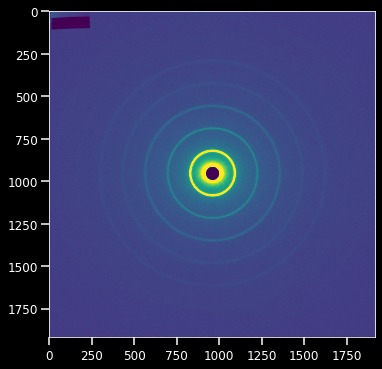

In [9]:
""" Retrieve data and plot image """
plt.imshow(det.evt.dat, clim=(0,60))
plt.show()

In [10]:
""" 
This cell is just an example of a function I was developing using a notebook 
like that. Just adding it as an additional example on how this can be done. 
For quick iteration it can be most efficient to start with the function defined
in the notebook itself, as here.
Can be deleted, the notebook will run regardless.
"""

import pyFAI
from smalldata_tools.utilities import image_from_dxy

class azav_pyfai_local(DetObjectFunc):
    """
    Parameters
    ----------
    name: str
        Function name
    
    mask: array, optional
        User defined mask. 1 for valid pixels.
    
    calib_file: str, Path object, optional
        Path to a pyFAI calibration file
    """
    def __init__(self, **kwargs):
        self._name = kwargs.get('name','azav')
        super(azav_pyfai, self).__init__(**kwargs)
        
        self.mask = kwargs.pop('userMask',None)
        self.return2d = kwargs.pop('return2d','False')
        
        # azimuthal integrator argument
        self.calib_file = kwargs.pop('calib_file',None)
        if self.calib_file is not None:
            self.ai = pyFAI.load(str(self.calib_file))
        else:
            self._ai_kwargs = kwargs.pop('ai_kwargs',None)
            assert self._ai_kwargs is not None, \
                "Need either a calibration file or a set of keywords arguments to instantiate the pyFAI integrator."
            # self.ai = pyFAI.azimuthalIntegrator.AzimuthalIntegrator(**self._ai_kwargs) # why does it not work?
            self.ai = pyFAI.AzimuthalIntegrator(**self._ai_kwargs)
        print(f'Created azimuthal integrator for {self._name}')
        
        # integration arguments
        self.pol_factor = kwargs.pop('polarization_factor',1)
        self.npts = kwargs.pop('npts_radial',256)
        self.npts_az = kwargs.pop('npts_az',360)
        # self.radial_range = kwargs.pop('radial_range',None)
        # self.az_range = kwargs.pop('azimuthal_range',None)
        self._units = kwargs.pop('int_units','2th_deg') # q_A^-1, 2th_deg, r_mm
        self._azav_kwargs = kwargs.pop('azav_kwargs',{}) # additional arguments for integration
        return

    def setFromDet(self, det):
        super(azav_pyfai, self).setFromDet(det)
        # geometry
        self.ix = det.ix
        self.iy = det.iy
        
        if self.calib_file is None: # use calib value if calib file is given
            if len(det.pixelsize)==2:
                if det.pixelsize[0]>1:
                    self.ai.pixel1 = det.pixelsize[0]*1e-6
                    self.ai.pixel2 = det.pixelsize[1]*1e-6
                else:
                    self.ai.pixel1 = det.pixelsize[0]
                    self.ai.pixel2 = det.pixelsize[1]
            else:
                if det.pixelsize[0]>1:
                    self.ai.pixel1 = det.pixelsize[0]*1e-6
                    self.ai.pixel2 = det.pixelsize[0]*1e-6
                else:
                    self.ai.pixel1 = det.pixelsize[0]
                    self.ai.pixel2 = det.pixelsize[0]
        
        # use cmask by default. Note: pyFAI uses 0 for valid pixel.
        if self.mask is not None and det.cmask is not None and self.mask.shape==det.cmask.shape:
            print('Use user mask and cmask')
            self.mask = ~(self.mask.astype(bool)&det.cmask.astype(bool))
        else:
            print('Use default detector masks')
            try:
                self.mask = ~(det.cmask.astype(bool)&det.mask.astype(bool))
            except:
                if det.ped is None:
                    self.mask = None
                else:
                    try:
                        self.mask = ~(np.ones_like(det.ped).astype(bool))
                    except:
                        self.mask = None
        if self.mask.ndim==3:
            self.mask = image_from_dxy(self.mask, self.ix, self.iy)
            
        print(f'Azimuthal integrator:\n{func.ai}')
        return
            
    def setFromFunc(self, func=None):
        return
        
    def process(self, data):
        if data.ndim==3:
            data = image_from_dxy(data, self.ix, self.iy)
        out = self._process(data)
        return out
    
    def _process(self, data):
        if self.return2d:
            I, q, az = self.ai.integrate2d(data, self.npts, self.npts_az, unit=self._units, 
                                           mask=self.mask, method='cython', **self._azav_kwargs)
            return {'intensity':I, 'q': q, 'az':az}
        else:
            q, I = self.ai.integrate1d(data, self.npts, unit=self._units, 
                                       mask=self.mask, method='cython', **self._azav_kwargs)
            return {'intensity':I, 'q': q}